## The N-Body Problem
This is a classic problem that's been of interest since the time of Newton. As it relates to the positions in of heavenly bodies, it was at the center of great debates that took place during the 1500s and involved such luniaries as Tycho Brahe (my favorite), Nicolaus Copernicus, Galileo, and Kepler.

We'll attack the problem with a brute force approach, adding up all the forces occurring between bodies. However, many good alternatives exist.

### Two bodies
Consider a force such as gravity, which pulls the moon toward the Earth *and the Earth toward the moon*. Generalize these two bodies to a pair of particles.

Suppose the particles are numbered 1 and 2. The force on 1 due to 2 will be labeled $\mathbf{F}_{12}$. Note it is a vector quantity. What about the force on 2 due to 1? Well, it's going to be anti-symmetric in the cases we will consider, $\mathbf{F}_{12} = -\mathbf{F}_{21}$. The force will act along the line between the two partcles. It will act in a plane containing the particles. The strength of the force will be a function of the distance between particles. What might this force look like? It will be a *central force*, expressed as

$$\mathbf{F}_{12}(\mathbf{r}) = |F_{12}(r)|\mathbf{\hat r}_{12}.$$

This is like what we've seen before where the magnitude is abstracted as $ |\mathbf{F}_{12}(\mathbf{r})|$, and we focus on the direction in $\mathbf{\hat{r}}_{12}$. 

This direction is given by
$$\mathbf{\hat{r}}_{12} = \frac{\mathbf{r}_1 - \mathbf{r}_2}{|\mathbf{r}_1 - \mathbf{r}_2|},$$
which points from 2 to 1.

![The difference in vectors.](vector_diff.png)

So, now we know the direction of this abstract force. How do we account for its working in both directions? That is particle 1 on 2 and 2 on 1.

It is convenient to write the forces in a matrix, where the matrix entry $\mathcal{F}_{ij}$ is the force of $j$ on $i$. There is no self-interaction; $\mathcal{F}_{ii}$=0.

$$\mathcal{F} =
\begin{bmatrix}
0 & \mathbf{F}_{12}  \\
\mathbf{F}_{21}&0\\
\end{bmatrix}
=
\begin{bmatrix}
0 & \mathbf{F}_{12}  \\
-\mathbf{F}_{12}&0\\
\end{bmatrix}$$

Such a matrix has two important properties; 
* the sum of each row is the total force on particle $i$ - $\mathbf{F}_i = \sum_j \mathcal{F}_{ij}$
* the matrix is anti-symmetric, so only the upper triangle needs to be computed.

But, what about those entries in that matrix - it looks like **they should be vectors**. In practice, it will be useful to maintain a scalar matrix for each dimension, a matrix of the $x$ components of force, $\mathcal{F}^x_{ij}$, and $y$ components, $\mathcal{F}^y_{ij}$, etc. 

### Three and more bodies
It probably occurred to you that the matrices are a lot of work when the forces are just $\mathbf{F}_{12}$ and $-\mathbf{F}_{12}$; the result of a single calculation. But, watch what happens with three bodies.

![The positions of and vectors between three bodies.](3body.png)

$$\mathcal{F} =
\begin{bmatrix}
0 & \mathbf{F}_{12} & \mathbf{F}_{13} \\
\mathbf{F}_{21} & 0 & \mathbf{F}_{23}\\
\mathbf{F}_{31}  & \mathbf{F}_{32} & 0
\end{bmatrix}$$

In this case, the sums of the rows are critical because because each body is attracted to 2 other bodies. But the formalism is powerful and appropriate. How many unique calculations need to be done? 

$$\mathcal{F} =
\begin{bmatrix}
0 & \mathbf{F}_{12} & \mathbf{F}_{13} \\
-\mathbf{F}_{12} & 0 & \mathbf{F}_{23}\\
-\mathbf{F}_{13}  & -\mathbf{F}_{23} & 0
\end{bmatrix}$$

Just 3, the upper triangle of the matrix. The most important aspect is, again, the fact that the total force on each particle is computed by summing its row:

$$\mathbf{F}_i = \sum_j \mathcal{F}_{ij}$$

With this statement, I think we see the sketch of the n-body algorithm. First we fill in a matrix:

```python
for i in range(len(particles):
    for j range(i+1,len(particles)):
        rij = particles.r(i) - particles.r(j)
        Fmatrix[i,j] = f(rij) * rij / norm(rij)
```

Then we find the force on each particle with sums over the rows of `FMatrix`

The generalization from three bodies to n-bodies is superficial.

There are opportunities to vectorize the operations by using `repmat` to create highly redundant arrays of coordinate data. Doing this may interest you, but it isn't necessary. It does tend to obfuscate code. You should also be able to speed code using `numba` or even `jax`. This assignment is especially ripe for optimization.

### The force
It has been worthwhile to abstract the force. As you can see in the psuedo-code/Python above, a function handle is a nice mechanism for this. However, we'll be concerned with gravitational forces in this class. That force is

$$\mathbf{F}_{12} = -G \frac{m_1m_2}{r_{12}^2}\mathbf{\hat{r}}_{12}$$

Which can more conveniently be written

$$\mathbf{F}_{12} = -G \frac{m_1m_2}{r_{12}^3}\mathbf{r}_{12}$$

If you are curious about why we generalize, let me provide at least one example. There is a rich literature in molecular dynamics which involves the use of Lennard-Jones type potentials

$$4\epsilon \left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^{6}\right]$$

Which describe weak attraction/strong repulsion. Forces are found by differentiation of the potential.

Of late, this concept has been extended to something called *discrete-element modeling*, which is good for large assemblages of granular material.

### Objective

Write an ODE function that provides the derivatives for the n-body problem. Assume as you have in the past that the state is entering as some vector `y` and the function will return `dydt`, or $\frac{dy}{dt}$. To match signatures, the function will have to accept a `t` or time that is not used, and a `p` which is a parameter. Here, it suggest `p` be made a dictionary of parameters.

The difficulties to be resolved in implementation include

* accounting for the masses of the particles.
* accounting for the dimension of the problem.
* accounting for the half way point, or where the position information stops, and the velocity information begins.
* not computing the same thing twice; only find $\mathbf{F}_{ij}$, not $\mathbf{F}_{ji}$. But, account for both.
* summing the columns so that each row's sum is the force on a particle.
* determining the acceleration and not the mass.
* handling a parameter called `fix_first` that prevents the first particle from moving. This is useful for simulating massive objects like the sun, and will help with a simulation of the helium atom.

Below, you will find the signature for the function, and some test data results to determine if the function is working correctly. Finish the function and verify the test data is giving the correct outputs.

In [28]:
from numpy import zeros,array,linspace,sum,transpose
import numpy as np

import funcs
from numpy.linalg import norm

def gravitational(rij,i,j,p):
    """
    Using the dictionary of parameters p return the gravitational force between particles i
    and j. We will assume that the vector between them has already been computed as rij.

    Returns a vector force, having d components where d is the dimension of the problem.
    
    """
    return rij * -p['G'] * p['m'][i] * p['m'][j] / (norm(rij)**3)
    

def n_body(t,y,p):
    """
    Develop the code that accepts a state vector y for N particles in d dimensions.
    For example, in 3 dimensions:
    y = [x1, y1, z1, x2, y2, z2, ... vx1, vy1, vz1, vx2, vy2, vz2,...]
    Normally, this would be up to you, but for this assignment it
    is better you follow my lead, because I have many interesting 
    initial conditions (y0) for you to explore.

    The function should then compute dydt for each of the input values.
    It should do so using a force function that computes the magnitude of force.
    That function should be a function handle in parameter dictionary p.

    The force must be compute between every pair of particles i,j
    This requires nested loops. 
    Record the forces in a matrix. 
    The sum of each row of the matrix corresponds to the total force on a particle.
    The dictionary p will contain any and all additional parameters needed in the calculation.
    """
    masses = p['m']
    N = len(masses)
    d = p['dimension']
    FMatrix = np.zeros((N,N,d))
    midpoint = int(len(y)/2)
    
    dydt = np.zeros(len(y))
    dydt[0:midpoint] = y[midpoint:]     
    
    pos = np.array(y[:N*d]).reshape(N,d)
    
    for i in range(N):
        #Identify ith position vector
        vi = pos[i]
        
        for j in range(i+1,N): 
            #jth position vector
            vj = pos[j]
            rij = vi-vj
        
            fij = p['force'](rij,i,j,p)
            
            FMatrix[i,j] = fij
            FMatrix[j,i] = -fij

    #Sum forces on ith vector and map to dydt    
    for i in range(N):
        i_dydt = np.sum(FMatrix[i],axis=1)
        '''print(i_dydt)
        print(i_dydt.shape)
        print("dydt")
        print(dydt)
        print(dydt.shape)'''
        
        #set velocity half of to force taken from FMatrix, divide my masses to get force because F=ma
        dydt[midpoint + i*d:midpoint + (i+1)*d] = np.sum(FMatrix[i],axis=0)/masses[i]
    
    '''print(FMatrix)
    print(FMatrix.shape)
    print(f"dydt:{dydt}")'''
    return dydt

p = {'m':[1,1,1],'G':1,'dimension':2,'force':gravitational,'fix_first':False}
y0 = [1,1,3,3,5,5,0,0,0,0,0,0]
n_body(0, y0, p)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.11048543,  0.11048543,  0.        ,  0.        ,
       -0.11048543, -0.11048543])

In [29]:
"""
Test data - make sure that your function reproduces the following.
Why not add a row of differences and make sure they are zero?
"""

# Order is all positions then all velocities grouped by body.
# eg, three bodies in two dimensions:
# x1,y1,x2,y2,x3,y3,vx1,vy1,vx2,vy2,vx3,vy3


from prettytable import PrettyTable
from numpy import float128

euler      = np.array([0,0,1,0,-1,0,0,0,0,.8,0,-.8])
four_body  = np.array([1.382857,0,\
                   0,0.157030,\
                  -1.382857,0,\
                   0,-0.157030,\
                   0,0.584873,\
                   1.871935,0,\
                   0,-0.584873,\
                  -1.871935,0],dtype=float128)
helium_1 = np.array([0,0,2,0,-1,0,0,0,0,.95,0,-1])

# The data structure holding parameters. You need not
# do it this way, but it's nice.

p = {'m':[1,1,1],'G':1,'dimension':2,'force':gravitational,'fix_first':False}
p4 = {'m':[1,1,1,1],'G':1,'dimension':2,'force':gravitational,'fix_first':False}
phe = {'m':[2,-1,-1],'G':1,'dimension':2,'force':gravitational,'fix_first':True}

headings = ['RUN','x1','y1','x2','y2','x3','y3','vx1','vy1','vx2','vy2','vx3','vy3']
t = PrettyTable(headings)
t.add_row(['euler']+list(n_body(0,euler,p)))

t.add_row(['He']+list(n_body(0,helium_1,phe)))
print(t)

headings = ['RUN','x1','y1','x2','y2','x3','y3','x4','y4','vx1','vy1','vx2','vy2','vx3','vy3','vx4','vy4']
t = PrettyTable(headings)
t.add_row(['4 body']+list(n_body(0,four_body,p4)))
print(t)

+-------+-----+-----+-----+------+-----+------+------+-----+---------------------+------+--------------------+------+
|  RUN  |  x1 |  y1 |  x2 |  y2  |  x3 |  y3  | vx1  | vy1 |         vx2         | vy2  |        vx3         | vy3  |
+-------+-----+-----+-----+------+-----+------+------+-----+---------------------+------+--------------------+------+
| euler | 0.0 | 0.0 | 0.0 | 0.8  | 0.0 | -0.8 | 0.0  | 0.0 |        -1.25        | 0.0  |        1.25        | 0.0  |
|   He  | 0.0 | 0.0 | 0.0 | 0.95 | 0.0 | -1.0 | 0.75 | 0.0 | -0.3888888888888889 | -0.0 | 1.8888888888888888 | -0.0 |
+-------+-----+-----+-----+------+-----+------+------+-----+---------------------+------+--------------------+------+
+--------+-----+----------+----------+-----+-----+-----------+-----------+-----+---------------------+-----+-----+---------------------+--------------------+-----+-----+--------------------+
|  RUN   |  x1 |    y1    |    x2    |  y2 |  x3 |     y3    |     x4    |  y4 |         vx1         

(10000, 12)


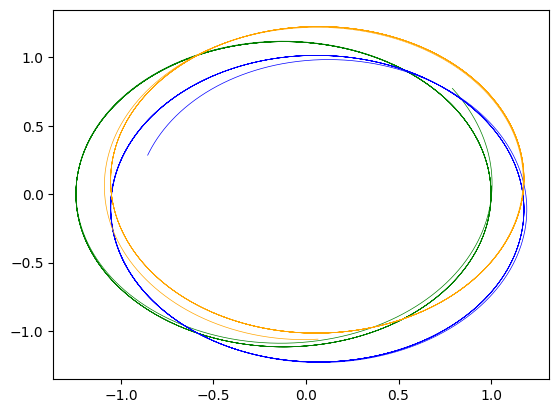

In [ ]:
""" 
Second test - see if you can reproduce the following
"""

#from ode import *
import matplotlib.pyplot as plt

lagrange_equilateral = np.array([
    1.0, 0.0,                   # x1, y1
    -0.5, 0.86602540378,        # x2, y2
    -0.5, -0.86602540378,       # x3, y3
    0.0, 0.8,                   # vx1, vy1
    -0.692820323, -0.4,         # vx2, vy2
    0.692820323, -0.4           # vx3, vy3
])
y0 = lagrange_equilateral
p = {'m':np.array([1,1,1]),'G':1,'dimension':2,'force':gravitational,'fix_first':False}
dt = .005
t_span = [0,50]

#had to swap y and t order to match my ode solver
y, t = funcs.solve_ode(n_body,t_span, y0, funcs.EulerRichardson,
        p,first_step=dt)
print(y.shape)
for i,c in zip([0,2,4],['green','blue','orange']):
    plt.plot(y[:,i],y[:,i+1],'-',color=c,lw=.5)
